# 01 – Exploração do Snapshot

Primeiro notebook do **creditlab**.

Nele, vamos:
1. Instanciar o `CreditDataSynthesizer`.
2. Gerar a *safra 0* (snapshot) para alguns grupos homogêneos.
3. Fazer uma exploração inicial: contagem de contratos por grupo, estatísticas descritivas e um histograma de dias em atraso.

⚠️ Este notebook assume que o módulo `credit_data_synthesizer.py` está no mesmo diretório ou em `PYTHONPATH`.

In [24]:
import sys
from pathlib import Path

# Adiciona o diretório-pai ao sys.path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import matplotlib.pyplot as plt


from importlib import reload
import credit_data_synthesizer as cds
reload(cds)  # garante versão atual no notebook

from credit_data_synthesizer import (
    CreditDataSynthesizer,
    default_group_profiles,   # função helper já incluída no módulo
)

## Parâmetros iniciais

In [ ]:
# ----- parâmetros que você quer -----
n_groups = 10
contracts_per_group = 10_000
n_safras = 36
seed = 0

# 1) Obtenha os perfis padrão e pegue só os três primeiros
group_profiles = default_group_profiles(n_groups)

# 2) Instancie o sintetizador
synth = CreditDataSynthesizer(
    group_profiles=group_profiles,
    contracts_per_group=contracts_per_group,
    n_safras=n_safras,
    random_seed=24,
)

In [33]:
df_panel['safra'].value_counts()

safra
202507    20000
Name: count, dtype: int64

## Geração da safra 0

In [26]:
# 3) Gere os dados
df_snapshot, df_panel, df_trace = synth.generate()

print(f"Snapshot gerado com {len(df_snapshot):,} linhas")
display(df_snapshot.head())

Snapshot gerado com 20,000 linhas


,id_contrato,id_cliente,grupo_homogeneo,data_inicio_contrato,data_ref,safra,dias_atraso,nivel_refinanciamento,idade_cliente,sexo,...,tempo_no_emprego_anual,num_dependentes,tipo_residencia,score_bureau_externo,qtd_consultas_bureau_3m,dia_vencimento_parcela,tipo_garantia,ltv_inicial_pct,renda_liquida_disp_pct,subcluster
0,0,1382675336,GH1,2024-07-25,2025-07-08,202507,0,0,26,F,...,0.784791,0,propria,656,6,10,sem,49.443012,0.663383,8
1,1,1330268836,GH1,2025-05-03,2025-07-08,202507,30,0,70,F,...,0.671071,0,financiada,368,5,14,sem,98.198906,0.475614,15
2,2,1751192118,GH1,2025-06-27,2025-07-08,202507,60,0,28,M,...,2.136993,4,familiar,475,10,17,sem,61.055351,0.370821,4
3,3,1405177315,GH1,2025-07-04,2025-07-08,202507,30,0,22,M,...,0.082358,4,familiar,573,2,14,avalista,89.325966,0.172974,12
4,4,1784646613,GH1,2025-05-30,2025-07-08,202507,30,0,45,F,...,0.196372,4,familiar,564,8,4,imovel,61.106674,0.662395,13


### Contagem de contratos por `grupo_homogeneo`

In [ ]:
df_snapshot['grupo_homogeneo'].value_counts()

safra
202507    20000
Name: count, dtype: int64

### Estatísticas descritivas das variáveis numéricas

In [28]:
cols_numericas = df_snapshot.select_dtypes(include='number').columns.drop(['id_contrato', 'id_cliente'])

agg_df = (
    df_snapshot[cols_numericas.tolist() + ['grupo_homogeneo']]
    .groupby('grupo_homogeneo')
    .agg(['min', 'mean', 'max'])
)

# Flatten columns
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
agg_df.reset_index(inplace=True)

# Supondo que agg_df tenha a coluna 'grupo_homogeneo'
agg_df = agg_df.copy()
agg_df['grupo_idx'] = agg_df['grupo_homogeneo'].str.extract(r'GH(\d+)').astype(int)
agg_df = agg_df.sort_values('grupo_idx').drop(columns='grupo_idx')

agg_df.head(10)

,grupo_homogeneo,dias_atraso_min,dias_atraso_mean,dias_atraso_max,nivel_refinanciamento_min,nivel_refinanciamento_mean,nivel_refinanciamento_max,idade_cliente_min,idade_cliente_mean,idade_cliente_max,...,dia_vencimento_parcela_max,ltv_inicial_pct_min,ltv_inicial_pct_mean,ltv_inicial_pct_max,renda_liquida_disp_pct_min,renda_liquida_disp_pct_mean,renda_liquida_disp_pct_max,subcluster_min,subcluster_mean,subcluster_max
0,GH1,0,26.8650,90,0,0.0,0,18,45.8455,74,...,28,40.053909,69.986107,99.992134,0.101108,0.452185,0.799308,0,7.4740,15
2,GH2,0,27.5100,90,0,0.0,0,18,46.6400,74,...,28,40.023079,69.682999,99.899315,0.101542,0.445882,0.799553,0,7.4650,15
3,GH3,0,26.5575,90,0,0.0,0,18,46.1005,74,...,28,40.060902,69.428322,99.887878,0.100653,0.451757,0.799300,0,7.4615,15
4,GH4,0,25.2000,90,0,0.0,0,18,45.0650,74,...,28,40.018497,70.145927,99.995499,0.100848,0.448224,0.799942,0,7.4745,15
5,GH5,0,23.5500,90,0,0.0,0,18,46.5240,74,...,28,40.008743,70.070976,99.993935,0.101486,0.446435,0.799154,0,7.4770,15
6,GH6,0,21.3450,90,0,0.0,0,18,45.7525,74,...,28,40.020672,69.954567,99.967400,0.101301,0.448992,0.799730,0,7.4825,15
7,GH7,0,19.9800,90,0,0.0,0,18,45.4510,74,...,28,40.017155,70.089439,99.948807,0.100680,0.449027,0.799554,0,7.4690,15
8,GH8,0,18.9600,90,0,0.0,0,18,45.2635,74,...,28,40.003994,70.232635,99.998222,0.100631,0.453036,0.799883,0,7.4795,15
9,GH9,0,17.0250,90,0,0.0,0,18,46.5380,74,...,28,40.001537,70.181564,99.995895,0.100285,0.455650,0.799816,0,7.4710,15
1,GH10,0,15.3150,90,0,0.0,0,18,45.9050,74,...,28,40.057323,70.037621,99.963982,0.100337,0.456457,0.799975,0,7.4690,15


### Distribuição de `dias_atraso`

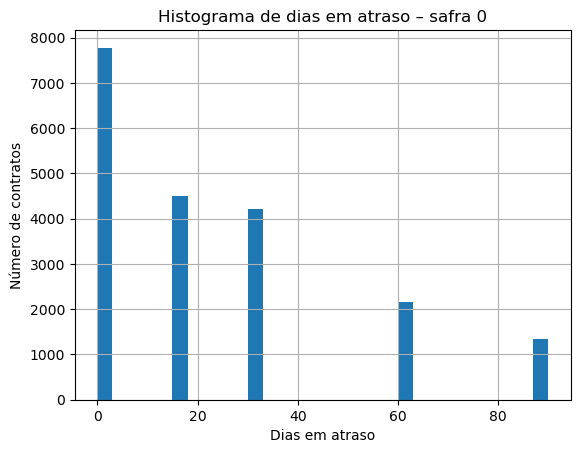

In [29]:
plt.figure()
df_snapshot['dias_atraso'].hist(bins=30)
plt.xlabel('Dias em atraso')
plt.ylabel('Número de contratos')
plt.title('Histograma de dias em atraso – safra 0')
plt.show()

In [31]:
df_snapshot.shape

(20000, 22)